<a href="https://colab.research.google.com/github/shreyasrajesh0308/NNDL-proj/blob/main/CNN_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN experiments 

# Running experiments on the BCI data with baseline CNNs.

Model Paper: 

### Load Data 

Load preprocessed data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
X_test = np.load("/content/drive/MyDrive/project_data/X_test.npy")
y_test = np.load("/content/drive/MyDrive/project_data/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/project_data/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/project_data/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/project_data/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/project_data/person_test.npy")



In [3]:
def map_classes(y) :

  for i in range(len(y)):

    if y[i] == 769:
      y[i] = 0
    elif y[i] == 770:
      y[i] = 1
    elif y[i] == 771:
      y[i] = 2
    elif y[i] == 772:
      y[i] = 3
    else:
      return None

  return y

In [4]:
y_train_valid = map_classes(y_train_valid)
y_test = map_classes(y_test)

### Indices for subject one training 

In [5]:
train_indeces = [ i for i in range(len(person_train_valid)) if person_train_valid[i]==0]
X_train_subject_1 = X_train_valid[train_indeces]
y_train_subject_1 = y_train_valid[train_indeces]

### Indices for subject one testing 

In [6]:
test_indeces = [ i for i in range(len(person_test)) if person_test[i]==0]
X_test_subject_1 = X_test[test_indeces]
y_test_subject_1 = y_test[test_indeces]

In [7]:
num_classes = len(np.unique(y_train_valid))

In [8]:
X_train_subject_1 = np.swapaxes(X_train_subject_1, 1, 2)
X_test_subject_1 = np.swapaxes(X_test_subject_1, 1, 2)

In [9]:
X_train_subject_1.shape

(237, 1000, 22)

In [10]:
X_test_subject_1.shape

(50, 1000, 22)

## Building a baseline with a fully CNN model for one subject alone, trained with one subject data

In [11]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt


In [15]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [16]:
model = make_model(input_shape=X_train_subject_1.shape[1::])

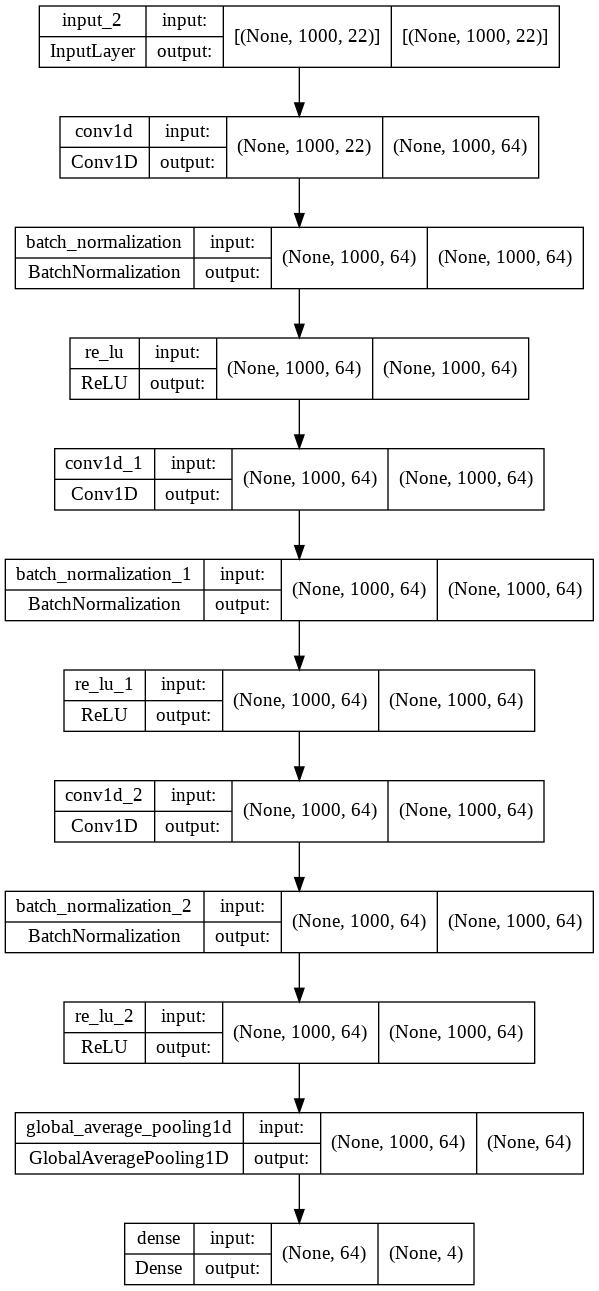

In [17]:
keras.utils.plot_model(model, show_shapes=True)

In [18]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train_subject_1,
    y_train_subject_1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
6/6 [==============================] - 12s 133ms/step - loss: 1.3980 - sparse_categorical_accuracy: 0.2646 - val_loss: 3.5180 - val_sparse_categorical_accuracy: 0.2292 - lr: 0.0010
Epoch 2/500
6/6 [==============================] - 0s 52ms/step - loss: 1.2918 - sparse_categorical_accuracy: 0.4074 - val_loss: 3.4695 - val_sparse_categorical_accuracy: 0.2292 - lr: 0.0010
Epoch 3/500
6/6 [==============================] - 0s 51ms/step - loss: 1.2242 - sparse_categorical_accuracy: 0.5079 - val_loss: 3.3793 - val_sparse_categorical_accuracy: 0.2292 - lr: 0.0010
Epoch 4/500
6/6 [==============================] - 0s 58ms/step - loss: 1.1717 - sparse_categorical_accuracy: 0.5344 - val_loss: 3.2198 - val_sparse_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 5/500
6/6 [==============================] - 0s 34ms/step - loss: 1.1315 - sparse_categorical_accuracy: 0.5767 - val_loss: 3.3219 - val_sparse_categorical_accuracy: 0.2292 - lr: 0.0010
Epoch 6/500
6/6 [==========================

In [21]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test_subject_1, y_test_subject_1)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 [==============================] - 0s 44ms/step - loss: 0.9757 - sparse_categorical_accuracy: 0.4600
Test accuracy 0.46000000834465027
Test loss 0.9757171869277954


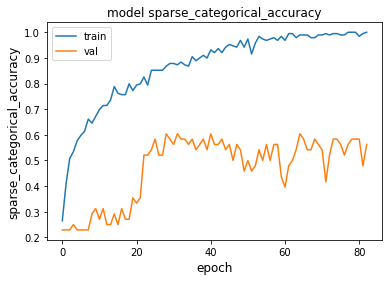

In [22]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()